# STAT 4710J Final Data Challenge

A taxi company is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an rider share app account. We consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days. **The data was collected at the end of June 30, 2014.**
We would like you to use this dataset to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help the company.
The data is in the attached file data_challenge.json. See below for a detailed
description of the dataset. 

**Data description**

city: city this user signed up in

phone: primary device for this user

signup_date: date of account registration; in the form ‘YYYYMMDD’

last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

avg_dist: the average distance in miles per trip taken in the first 30 days after signup

avg_rating_by_driver: the rider’s average rating over all of their trips

avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

surge_pct: the percent of trips taken with surge multiplier > 1

avg_surge: The average surge multiplier over all of this user’s trips

trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;

FALSE otherwise

weekday_pct: the percent of the user’s trips occurring during a weekday



Please include any code you wrote for the analysis.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis.
2. Build a predictive model to help the company determine whether or not a user will be active
on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.


**If you use Chatgpt in any of the sections, please state clearly how you reference Chatgpt, with a proper declaration, we might take you points off if we find duplicate codes produced from Chatgpt**

Grade break down: 60% on data analysis in the notebook (completeness, accuracy and interpretation) + 40% on test accuracy



In [1]:
#set up environment
import pandas as pd
import numpy as np
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

#load data and visualize
with open('data_challenge.json') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)
df.reset_index(inplace=True, drop=True)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,Winterfell,1,2014-01-27,3.5,1.67,2014-06-22,iPhone,33.3,True,16.7,2.10,4.8
1,King's Landing,1,2014-01-11,5.0,1.00,2014-06-08,iPhone,0.0,False,0.0,7.30,5.0
2,King's Landing,0,2014-01-23,3.0,1.00,2014-06-27,iPhone,0.0,True,100.0,4.00,5.0
3,King's Landing,0,2014-01-17,4.0,1.00,2014-05-31,Android,0.0,False,33.3,6.73,5.0
4,King's Landing,1,2014-01-28,5.0,1.16,2014-06-20,iPhone,26.9,True,50.0,2.48,4.8


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47500 entries, 0 to 47499
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    47500 non-null  object 
 1   trips_in_first_30_days  47500 non-null  int64  
 2   signup_date             47500 non-null  object 
 3   avg_rating_of_driver    39746 non-null  float64
 4   avg_surge               47500 non-null  float64
 5   last_trip_date          47500 non-null  object 
 6   phone                   47128 non-null  object 
 7   surge_pct               47500 non-null  float64
 8   ultimate_black_user     47500 non-null  bool   
 9   weekday_pct             47500 non-null  float64
 10  avg_dist                47500 non-null  float64
 11  avg_rating_by_driver    47311 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.0+ MB


In [3]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,47500.000000,39746.000000,47500.000000,47500.000000,47500.000000,47500.000000,47311.000000
mean,2.275158,4.602186,1.074716,8.852829,60.966623,5.799024,4.778400
std,3.789220,0.617603,0.222291,19.993570,37.064133,5.677958,0.447863
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.890000,5.000000
75%,3.000000,5.000000,1.050000,8.500000,100.000000,6.950000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,129.890000,5.000000


### 1. EDA
a. First of all, all the users will need to be labled by active or inactive, and categorical variables must be encoded. The null values must be accounted for. While the reason for the missing ratings cannot be inferred, it seems reasonable that the user/driver simply declined to input a rating. In this case, we will fill with the **mean value** so as to not affect the current distribution, which is primarily high ratings.

In [4]:
#fill missing values in avg_rating_by_driver and avg_rating_of_driver
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())

b. The target variable will be whether the user was active. Convert the signup date and last trip date to datetime objects. If the last trip is in June, then encode each user active as True, else False.

In [5]:
#set as datatime objects
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [6]:
#encode target variable 'active' as true or false for last trip in june
# you can add more lines before assigning the 'active' column
df['active'] = df['last_trip_date'] >= '2014-06-01'

#### What is the ratio of Active Users to Inactive Users?
Compute the percentage of active users among all users, and make a plot to visualize it.

In [7]:
ratios = df.groupby('active').active.value_counts()/len(df) * 100
ratios = pd.DataFrame(ratios).reset_index()
ratios

,active,count
0,False,62.418947
1,True,37.581053


[Text(0, 0, '62.4%'), Text(0, 0, '37.6%')]

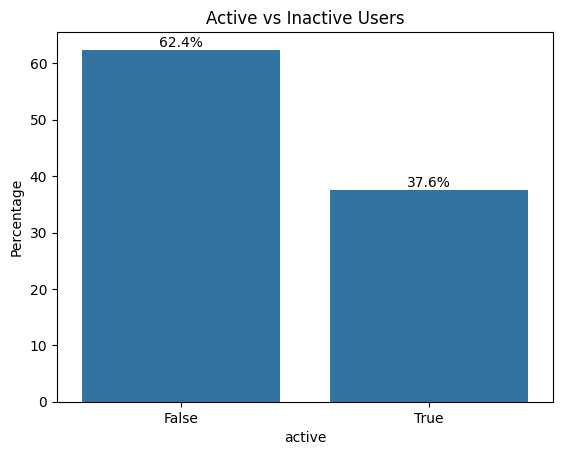

In [8]:
#Calculate ratio of active to all users
#Visualization
ax = sns.barplot(ratios, x=ratios['active'], y=ratios['count'])
plt.title('Active vs Inactive Users')
plt.ylabel('Percentage')
plt.bar_label(ax.containers[0], fmt='{:,.1f}%')

Unsurprisingly the classes are imbalanced, but not tremendously. This should not present too much of a problem while modeling.

c. In the cell below, show a visualization that you used to select features for your model.

Include:

1. At least one plot showing something meaningful about the data that helped you during feature selection, model selection, or both.

2. Two or three sentences describing what you plotted and its implications with respect to your features.



<Axes: xlabel='ultimate_black_user', ylabel='count'>

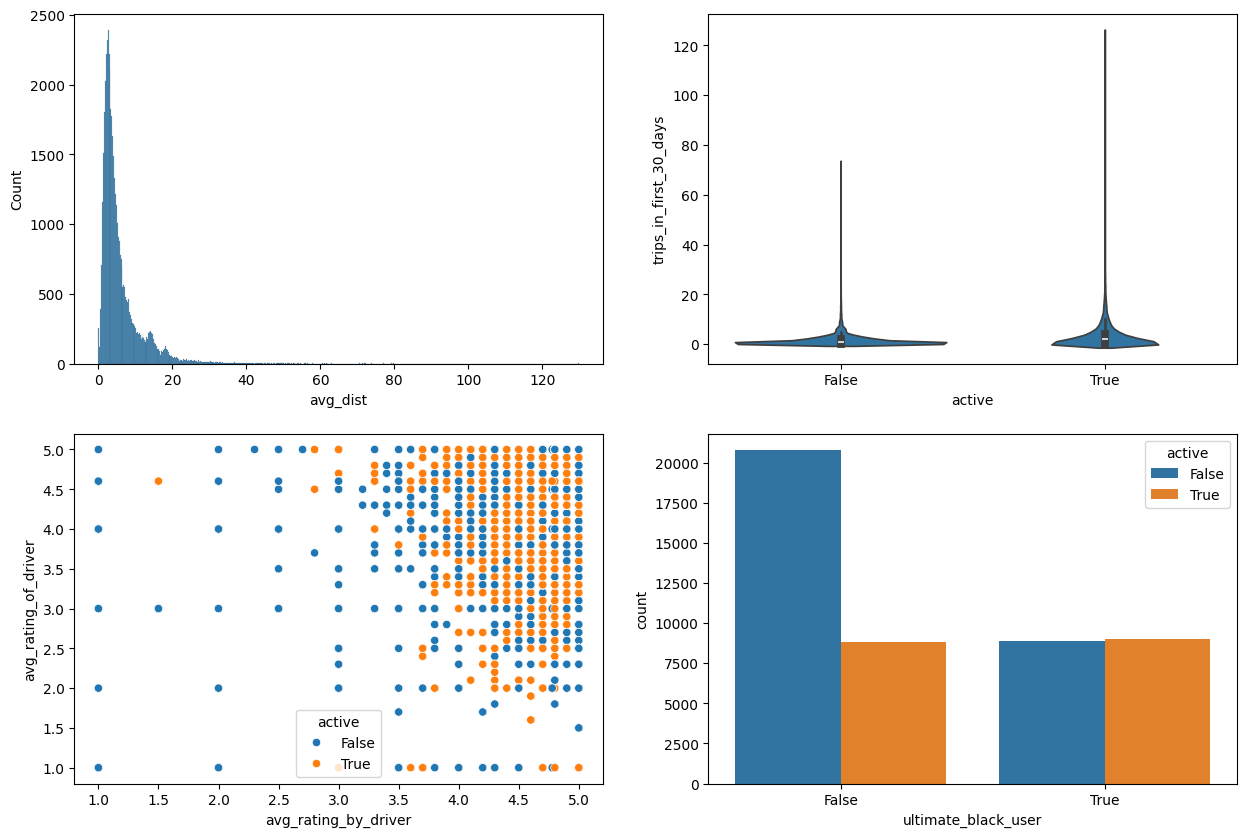

In [9]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15, 10)
sns.histplot(df, x='avg_dist', ax=ax[0,0])
sns.violinplot(df, y='trips_in_first_30_days', x='active', ax=ax[0,1])
sns.scatterplot(df, x='avg_rating_by_driver', y='avg_rating_of_driver', hue='active', ax=ax[1,0])
sns.countplot(data=df, x='ultimate_black_user', hue='active', ax=ax[1,1])

We can see from above that the plots show us very interesting features of the predictors
that we are dealing with. For plot (0,0) the distribution of the ave_dist is right skewed
and can be transformed to acheive a more normal distribution for better prediction by
linear models.

The other plots show the distribution with respect to the user 'active' label. We can see that
users who have high avg_rating and those who give high rating to drivers tend to be active. We
can also see that generally if a user is not a ultimate_black_user, there is qutie a high
chance that he is not active the past 30 days.

## 2. Modeling

Now, please perform feature engineering to build a model that can predict whether the users are active. (To get full credit, you need to make some visualization and try out several different models using cross validation)

In [10]:
df.head(1)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,Winterfell,1,2014-01-27,3.5,1.67,2014-06-22,iPhone,33.3,True,16.7,2.1,4.8,True


<Axes: xlabel='active', ylabel='surge_pct'>

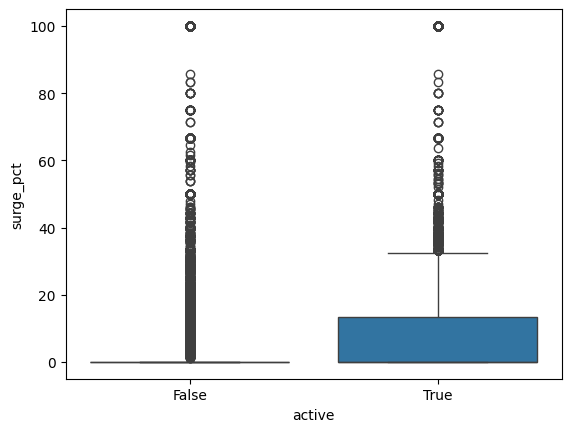

In [11]:
sns.boxplot(data=df, y='surge_pct',x='active')

We can see that there is a clear distinct difference between the surge_pct of the
active and non-active user. Where active users then to have higher surge percentage.

While there are a lot of outliers for the non-active users, we can still generally use
this predictor

In [12]:
df['city'].value_counts()

city
Winterfell        22138
Astapor           15723
King's Landing     9639
Name: count, dtype: int64

<Axes: xlabel='phone', ylabel='count'>

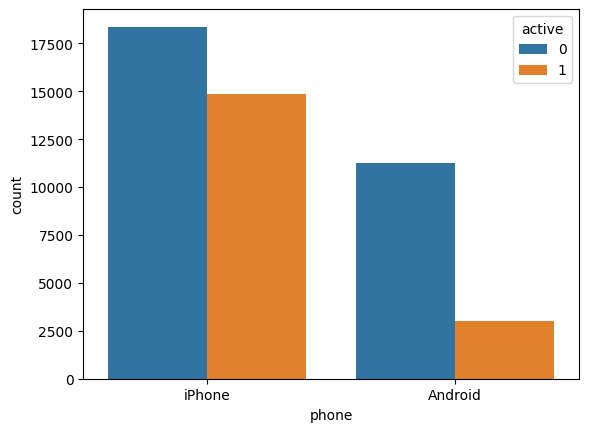

In [32]:
sns.countplot(data=df, x='phone', hue='active')

<Axes: xlabel='city', ylabel='count'>

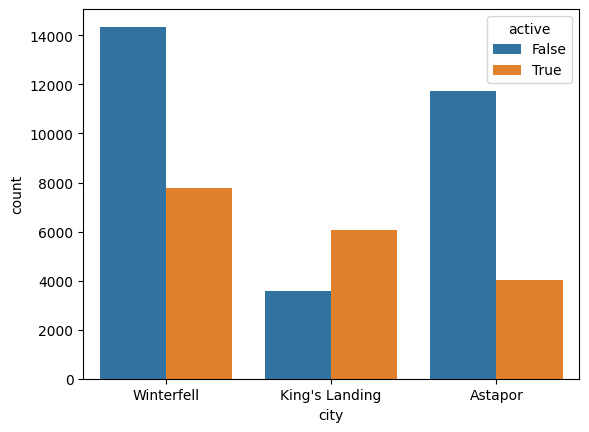

In [13]:
sns.countplot(data=df, x='city', hue='active')

We can also see that generally we King's Landing have more active user ratio and
Winterfell has the most absolute number of active users.

<Axes: xlabel='avg_dist', ylabel='Count'>

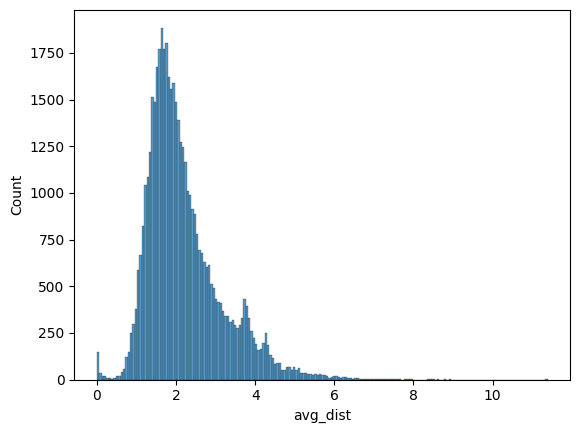

In [14]:
sns.histplot(df, x=np.sqrt(df['avg_dist']))

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import re

def feature_engine_pipe(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    if prediction_col == None:
        return data, None
    X = data.drop(columns=[prediction_col])
    Y = data.loc[:, prediction_col]
    return X, Y

def transform_bool(data, col):
    data[col] = data[col].astype(int)
    return data

def get_ohe_col(data, pattern):
    """
    Input:
      ohe_headers (list): list of headers from one-hot encoding
    Output:
      a list of the original columns
    """
    r = re.compile(pattern)
    return list(filter(r.match, data.columns))

def Sqrt_transform(data, col):
    data['Sqrt ' +col] = np.sqrt(data[col])
    return data 

def select_columns(data, columns, regex_col):
    """Select only columns passed as arguments."""
    col_copy = columns.copy()
    col_copy += get_ohe_col(data, regex_col)
    print(f'Selecting these {col_copy}')
    return data.loc[:, col_copy]

def feature_engine_final(data, response_col, pipeline):
    X, Y = feature_engine_pipe(data, pipeline, response_col)
    return X, Y

column_for_ml = [
        'active',
        'Sqrt avg_dist',
        'Sqrt trips_in_first_30_days',
        'avg_rating_of_driver', 'avg_surge',
        'Scaled surge_pct', 'Scaled weekday_pct',
        'avg_rating_by_driver',
        'ultimate_black_user'
    ]


def fill_missing_values(data, col):
    data[col] = data[col].fillna(data[col].mean())
    return data

def fill_missing_categorical(data, col):
    data[col] = data[col].fillna(data[col].mode()[0])
    return data

class DataframeFunctionTransformer():
    def __init__(self, func, col):
        self.func = func
        self.col = col
    def transform(self, input_df, **transform_params):
        return self.func(input_df, self.col)
    def fit(self, X, y=None, **fit_params):
        return self
class DataframeSelector():
    def __init__(self, func, col, regex_col):
        self.func = func
        self.col = col
        self.regex_col = regex_col
    def transform(self, input_df, **transform_params):
        print(f'{input_df.columns} will be filtered')
        return self.func(input_df, self.col, self.regex_col)
    def fit(self, X, y=None, **fit_params):
        return self
class DataframeOHETransfomer():
    def __init__(self, col):
        self.ohe = OneHotEncoder(drop='first', dtype=np.int32)
        self.col = col
    def transform(self, data, **transform_params):
        ohe_col = self.ohe.transform(data[[self.col]])
        ohe_col = pd.DataFrame(ohe_col.toarray(), columns=self.ohe.get_feature_names_out())
        return pd.concat([data, ohe_col], axis=1)
    def fit(self, X, y=None, **fit_params):
        self.ohe.fit(X[[self.col]])
        return self
class DataframeMinMaxTransfomer():
    def __init__(self, col):
        self.scaler = MinMaxScaler()
        self.col = col
    def transform(self, data, **transform_params):
        minmax_df = self.scaler.transform(data[[self.col]])
        df = pd.DataFrame(minmax_df, columns=["Scaled " + self.col])
        return pd.concat([data, df], axis=1)
    def fit(self, X, y=None, **fit_params):
        self.scaler.fit(X[[self.col]])
        return self

pipeline = Pipeline([
    ("0", DataframeFunctionTransformer(fill_missing_categorical, 'phone')),
    ("1", DataframeFunctionTransformer(fill_missing_values, 'avg_rating_by_driver')),
    ("1.1", DataframeFunctionTransformer(fill_missing_values, 'avg_rating_of_driver')),
    ("1.2", DataframeFunctionTransformer(transform_bool, 'active')),
    ("1.3", DataframeFunctionTransformer(transform_bool, 'ultimate_black_user')),
    ("2", DataframeFunctionTransformer(Sqrt_transform, 'avg_dist')),
    ("3", DataframeFunctionTransformer(Sqrt_transform, 'trips_in_first_30_days')),
    ("4", DataframeMinMaxTransfomer('weekday_pct')),
    ("5", DataframeMinMaxTransfomer('surge_pct')),
    ("6", DataframeOHETransfomer('phone')),
    ("7", DataframeOHETransfomer('city')),
    ("8", DataframeSelector(select_columns, column_for_ml, '^phone_|^city_')),
])

Since this is a classficiation problem, we will use classification algorithms
and we will test how well the algorithms run.

In [16]:
tmp = pipeline.fit_transform(df)
X = tmp.drop(columns=['active'])
y = tmp.loc[:, 'active']

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'active', 'Sqrt avg_dist',
       'Sqrt trips_in_first_30_days', 'Scaled weekday_pct', 'Scaled surge_pct',
       'phone_iPhone', 'city_King's Landing', 'city_Winterfell'],
      dtype='object') will be filtered
Selecting these ['active', 'Sqrt avg_dist', 'Sqrt trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'Scaled surge_pct', 'Scaled weekday_pct', 'avg_rating_by_driver', 'ultimate_black_user', 'phone_iPhone', "city_King's Landing", 'city_Winterfell']


In [17]:
# X, y = feature_engine_final(df, 'active', final_train_pipelines)

In [18]:
X.columns

Index(['Sqrt avg_dist', 'Sqrt trips_in_first_30_days', 'avg_rating_of_driver',
       'avg_surge', 'Scaled surge_pct', 'Scaled weekday_pct',
       'avg_rating_by_driver', 'ultimate_black_user', 'phone_iPhone',
       'city_King's Landing', 'city_Winterfell'],
      dtype='object')

In [19]:
X.describe()

,Sqrt avg_dist,Sqrt trips_in_first_30_days,avg_rating_of_driver,avg_surge,Scaled surge_pct,Scaled weekday_pct,avg_rating_by_driver,ultimate_black_user,phone_iPhone,city_King's Landing,city_Winterfell
count,47500.000000,47500.000000,47500.000000,47500.000000,47500.000000,47500.000000,47500.000000,47500.000000,47500.000000,47500.000000,47500.000000
mean,2.208420,1.123163,4.602186,1.074716,0.088528,0.609666,4.778400,0.376611,0.699368,0.202926,0.466063
std,0.960169,1.006818,0.564948,0.222291,0.199936,0.370641,0.446971,0.484541,0.458538,0.402182,0.498852
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.555635,0.000000,4.500000,1.000000,0.000000,0.333000,4.700000,0.000000,0.000000,0.000000,0.000000
50%,1.972308,1.000000,4.700000,1.000000,0.000000,0.667000,5.000000,0.000000,1.000000,0.000000,0.000000
75%,2.636285,1.732051,5.000000,1.050000,0.085000,1.000000,5.000000,1.000000,1.000000,0.000000,1.000000
max,11.396929,11.180340,5.000000,8.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000


In [20]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

logistic_regression = LogisticRegressionCV(cv=10,max_iter= 1000, random_state=42).fit(X, y)
print(f'The best score for logistic regression is {logistic_regression.score(X, y)}')

random_forest = RandomForestClassifier(max_depth=2, random_state=42)
random_forest_score = cross_val_score(random_forest, X, y, cv=10)
print(f'The scores are {random_forest_score}\n The mean score is {random_forest_score.mean()}')

The best score for logistic regression is 0.7133684210526315
The scores are [0.72231579 0.72021053 0.72652632 0.72757895 0.72905263 0.71263158
 0.72189474 0.724      0.72442105 0.72526316]
 The mean score is 0.7233894736842105


In [21]:
from sklearn.ensemble import AdaBoostClassifier


ada = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=42).fit(X, y)
ada_score = cross_val_score(ada, X, y, cv=10)
print(f'The scores are {ada_score}\n The mean score is {ada_score.mean()}')

The scores are [0.78231579 0.76926316 0.78084211 0.78421053 0.77705263 0.77831579
 0.77621053 0.78421053 0.77684211 0.78378947]
 The mean score is 0.7793052631578947


In [22]:

from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100).fit(X, y)
xgb_score = cross_val_score(xgb, X, y, cv=10)
print(f'The scores are {xgb_score}\nThe mean score is {xgb_score.mean()}')

The scores are [0.79305263 0.78231579 0.78610526 0.79389474 0.79368421 0.79347368
 0.78631579 0.79263158 0.79094737 0.79242105]
The mean score is 0.7904842105263158


In [23]:
# Lets try to tune the hyperparameters

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [130, 150, 180],
    'learning_rate': [0.2, 0.15],
}

xgb_grid = GridSearchCV(XGBClassifier(max_depth=5), param_grid, cv=10)
xgb_grid.fit(X, y)
print(f'The best parameters are {xgb_grid.best_params_} and the best score is {xgb_grid.best_score_}')

The best parameters are {'learning_rate': 0.2, 'n_estimators': 130} and the best score is 0.7927368421052632


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y, train_size=0.95, 
                                                   random_state=42, 
                                                   shuffle=True, stratify=y)

xgb_stratified = XGBClassifier(n_estimators=150,learning_rate=0.2).fit(X_train, y_train)
xgb_score = cross_val_score(xgb_stratified,X_train, y_train, cv=10)
print(f'The scoring with stratified samping on train set is {xgb_grid.score(X_train, y_train)}')
print(f'The scoring with stratified samping on test set is {xgb_grid.score(X_test, y_test)}')

The scoring with stratified samping on train set is 0.8139168975069252
The scoring with stratified samping on test set is 0.8181052631578948



## 3. Model Evaluation

The bottom line here is: Was the model useful? You need to check both **numerical metrics and visual metrics**. **Please explain different performance metrics and your results.**

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X, y):
    print(classification_report(model.predict(X), y))
    cm = confusion_matrix(model.predict(X), y)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['non-active','active'])
    cmd.plot()

              precision    recall  f1-score   support

           0       0.86      0.80      0.83     31873
           1       0.64      0.74      0.69     15627

    accuracy                           0.78     47500
   macro avg       0.75      0.77      0.76     47500
weighted avg       0.79      0.78      0.78     47500



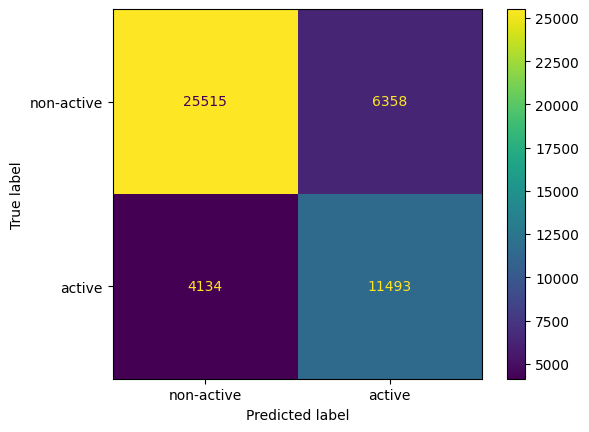

In [26]:
evaluate_model(ada, X, y)

              precision    recall  f1-score   support

           0       0.90      0.85      0.87     31428
           1       0.73      0.81      0.77     16072

    accuracy                           0.83     47500
   macro avg       0.81      0.83      0.82     47500
weighted avg       0.84      0.83      0.84     47500



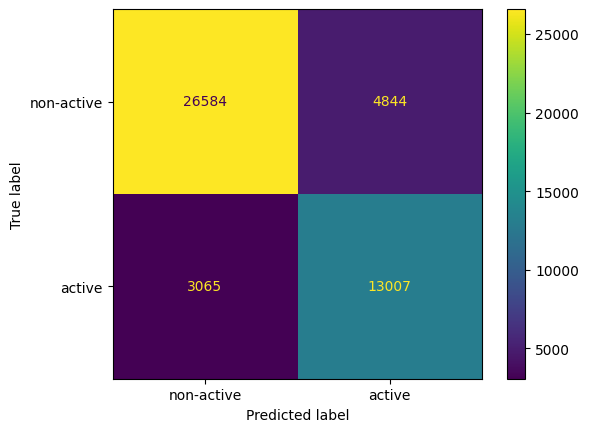

In [27]:
evaluate_model(xgb, X, y)

              precision    recall  f1-score   support

           0       0.88      0.83      0.86     31510
           1       0.70      0.78      0.74     15990

    accuracy                           0.81     47500
   macro avg       0.79      0.81      0.80     47500
weighted avg       0.82      0.81      0.82     47500



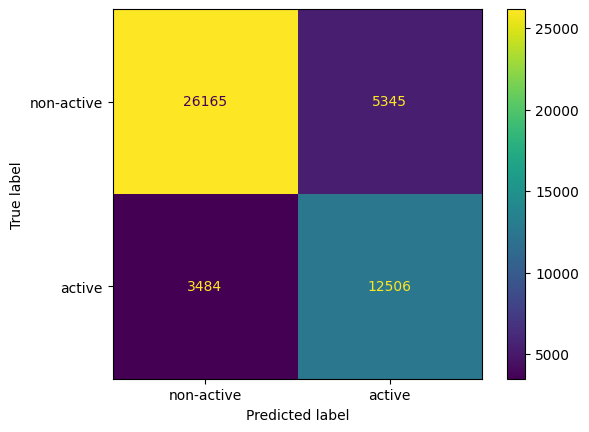

In [28]:
evaluate_model(xgb_grid.best_estimator_, X, y)

We can see that the basic XGBClassifier performed the best of all the models used.
This is with appoximately .83 accuracy, we also note that more could be done to
the training data such as clustering of some of the columns or removal of outlier
which could improve the model.


We also note that the number of non-active user is much
higher than the active user, thus the model has higher tendency to predict that the
user is non-active. This can be seen from the higher precision and recall on non-active
users compared to active users. Stratified sampling could be done to reduce this bias.

We also see that the improvement for changing the model is not drastic, thus more
could be done on the transformation aspect of the data. 


              precision    recall  f1-score   support

           0       0.90      0.84      0.87     31537
           1       0.72      0.81      0.76     15963

    accuracy                           0.83     47500
   macro avg       0.81      0.83      0.82     47500
weighted avg       0.84      0.83      0.83     47500



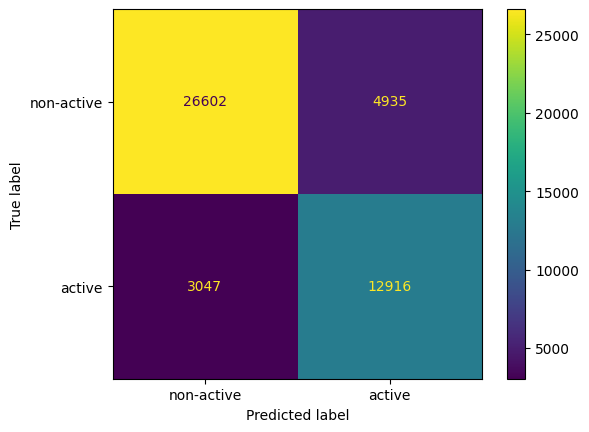

In [29]:
evaluate_model(xgb_stratified, X, y)

## 4. Final Submission




The following code will write your predictions on the test dataset to a CSV file. **You will need to submit this file to get credit for this question.**

Save your predictions in a 1-dimensional array called `test_predictions` (contains 0 and 1s). 

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. 



### Submission on Gitea

Please push all your work (ipynb, submission.csv) to the `-final` repo on Gitea. All your work should be on the master branch. 

### Submission on Canvas

Just in case you have issues with Git, submit the same items on Canvas.



In [30]:
test = pd.read_csv('test.csv')
test.reset_index(inplace=True, drop=True)
# create a dummy y value
test['active'] = 0
tmp = pipeline.transform(test)
X_test = tmp.drop(columns=['active'])


test_predictions = xgb_stratified.predict(X_test)


Index(['city', 'trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge',
       'phone', 'surge_pct', 'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'active', 'Sqrt avg_dist',
       'Sqrt trips_in_first_30_days', 'Scaled weekday_pct', 'Scaled surge_pct',
       'phone_iPhone', 'city_King's Landing', 'city_Winterfell'],
      dtype='object') will be filtered
Selecting these ['active', 'Sqrt avg_dist', 'Sqrt trips_in_first_30_days', 'avg_rating_of_driver', 'avg_surge', 'Scaled surge_pct', 'Scaled weekday_pct', 'avg_rating_by_driver', 'ultimate_black_user', 'phone_iPhone', "city_King's Landing", 'city_Winterfell']


In [31]:
submission_df = pd.DataFrame({ 
    "active": test_predictions
}, columns=['active'])
submission_df.to_csv("submission.csv", index=False)

print('Created a CSV file: submission.csv')
print('You may now upload this CSV file to Canvas for grading.')

Created a CSV file: submission.csv
You may now upload this CSV file to Canvas for grading.
